# Gap Time Calculations

Get n # of random points in a specific geographic region with associated gap times



## Setup Imports

(not relevant to repo, can skip) 

Adding module path to run correctly in examples folder

In [6]:
import sys
import os

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/gracekim/Documents/School_Everything_and_LEARNING/Stanford/SISL/loc-gsopt/src


## Imports

In [7]:
"""
Get n # of random points in a specific geographic region with associated gap times
"""

from sat_gen import satellites_from_constellation
from station_gen import gs_json, rand_gs_on_land,return_bdm_gs
from utils import load_earth_data, compute_all_gaps_contacts

from scipy.optimize import minimize
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Brahe Imports
import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba

# random points function
import random_land_points as rlp

## Setup 

In [11]:
############################### SETUP: ###############################

# Make sure to load in earth inertial data every start time!
load_earth_data('data/iau2000A_finals_ab.txt')

############################### STEP 1: Satellites ###############################

# Loading in a satellite constellation 
CONSTELLATIONS = sorted(['YAM', 'UMBRA', 'SKYSAT', 'ICEYE', 'FLOCK', 'HAWK', 'CAPELLA', 'LEGION', 'WORLDVIEW', 'GEOEYE',
                  'NUSAT'])

constellation = CONSTELLATIONS[3]

satellites = satellites_from_constellation(constellation)

############################### STEP 2: Scenario Generation ###############################

# Setting up Epochs
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # This is the epoch of the orbital elements
epc1 = epc0 + 86400 # checking over one day



Loading the latest Earth Orientation Data


# Cost Functions

In [14]:
def cost_func_gap( gs ,satellites = satellites[0:3], epc_start = epc0, epc_end = epc1, plot = False):

    _, _, gaps_seconds = compute_all_gaps_contacts(satellites, [gs],epc_start, epc_end, plot)

    return 3*np.mean(gaps_seconds) + np.std(gaps_seconds)

# Generating 50 Ground Stations and Contacts

In [23]:
lats = []
longs = []
gaps = []
for i in range(50):
    gs = rlp.random_points('Europe')[0]
    lon = gs[0]
    lat = gs[1]
    gs = return_bdm_gs(gs[0], gs[1])
    lats.append(lat)
    longs.append(lon)
    print(lat,lon)
    gap = cost_func_gap( gs ,satellites[0:3], epc0, epc1, False)
    gaps.append(gap)

67.92110388484224 121.61035560381708
60.79322952138212 134.38545055100917
57.15342834648297 77.76328770641678
70.52965235450117 141.04649688677608
62.434185879864145 105.07219504730487
70.45320057147971 26.262422735508792
65.69717879086735 128.6820007136392
63.143088529278856 38.21223735268343
70.17409256139128 30.28066409624498
66.39633447284452 24.675761340277944
63.28283243214244 61.34329858724083
48.460382546709724 23.31300551910521
39.26903901743132 -2.4634317900553206
70.09206704739539 152.70376862977673
63.919292443044434 38.57594031537769
56.946049759956665 -3.6690069868675033
47.28082542050547 13.586572950563799
47.787732040308846 26.42219971865437
66.5746267935116 126.34646266533316
60.33533026802403 22.256162801556833
50.25604552116908 17.711645951283522
68.00101579605249 101.36241311293554
47.52432283999254 138.6714624682792
60.09389069368139 104.15324538203066
53.59995642907565 -8.859840361673013
63.020695750739534 66.86044452291736
41.57541392033818 20.49010828215995
58.7

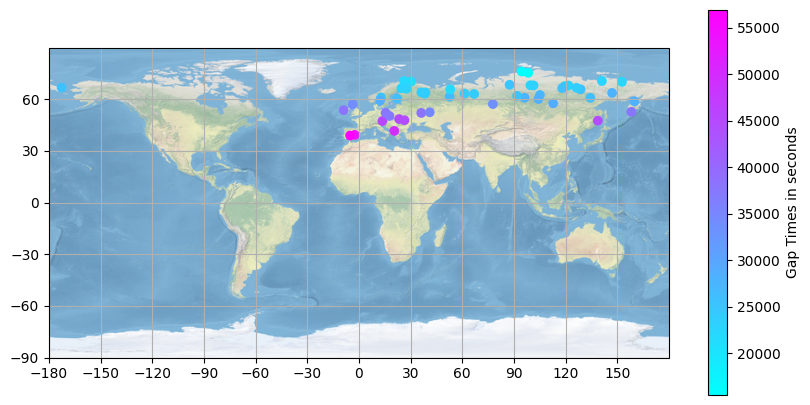

In [24]:
# Plotting Imports

import cartopy.crs as ccrs

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()
c = 'b' # Set the plot color

ax.set_yticks(np.arange(-90, 90, 30))
ax.set_xticks(np.arange(-180, 180, 30))
sc = ax.scatter(x=longs, y=lats, c=gaps,cmap = 'cool')
cbar = fig.colorbar(sc)
cbar.set_label('Gap Times in seconds')
